# Visualization - exploring the data

Let's begin with the imports...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
import gensim
from wordcloud import WordCloud, STOPWORDS
# import tensorflow as tf
# from tensorflow.python.keras import models
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import Dropout

from seinfeld_laugh_corpus import corpus
from seinfeld_playground import *

%load_ext autoreload
%autoreload 2

Load the corpus into a DataFrame, and create a separate DataFrame for the 4 main characters.

In [2]:
df = load_corpus()
df_main_characters = df[df['character'].isin(["JERRY", "ELAINE", "KRAMER", "GEORGE"])]

Let's see how each entry in our DataFrame looks like...

In [3]:
df.head(1)

character   end episode_name  episode_num  is_funny  laugh_time  length  \
0     JERRY  3.05    The Watch            6      True         3.6   1.944   

   line_num  num_words  season  start  total_lines  \
0         0          9       4  1.106          486   

                                                 txt  global_episode_num  
0  Here's what happened last  week, incase you mi...                   1

## Analyze the sentences' length, both in time (seconds) and in #words.
Split for each character and for funny/not-funny sentences.  
Are funny sentences longer then not-funny ones?

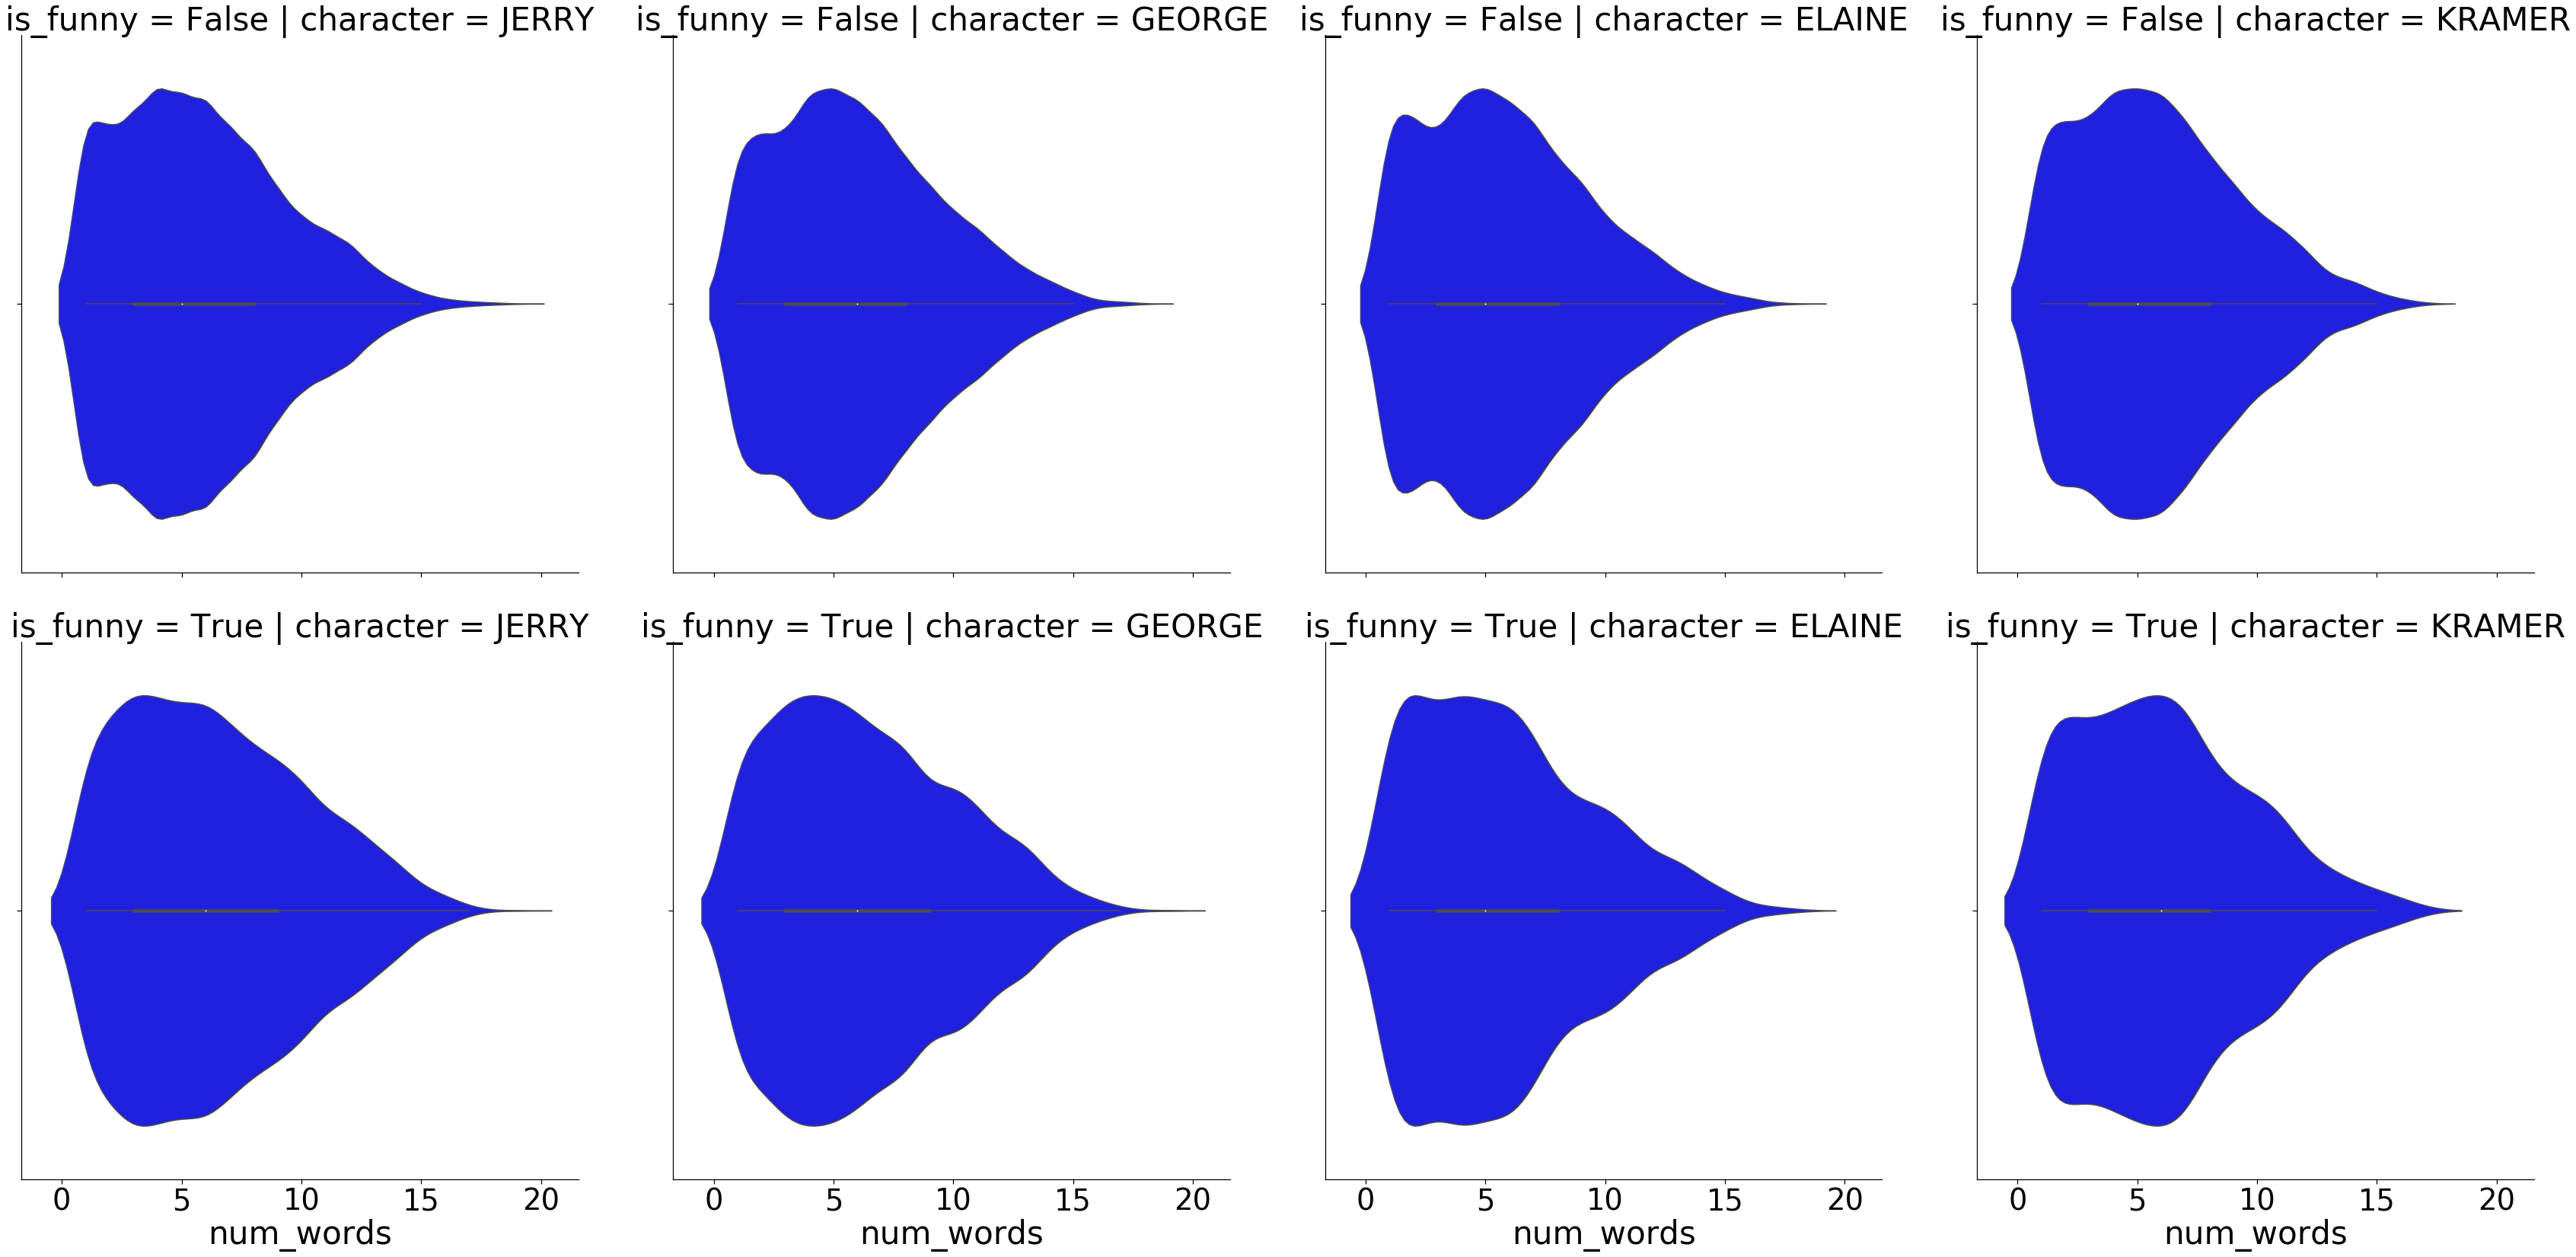

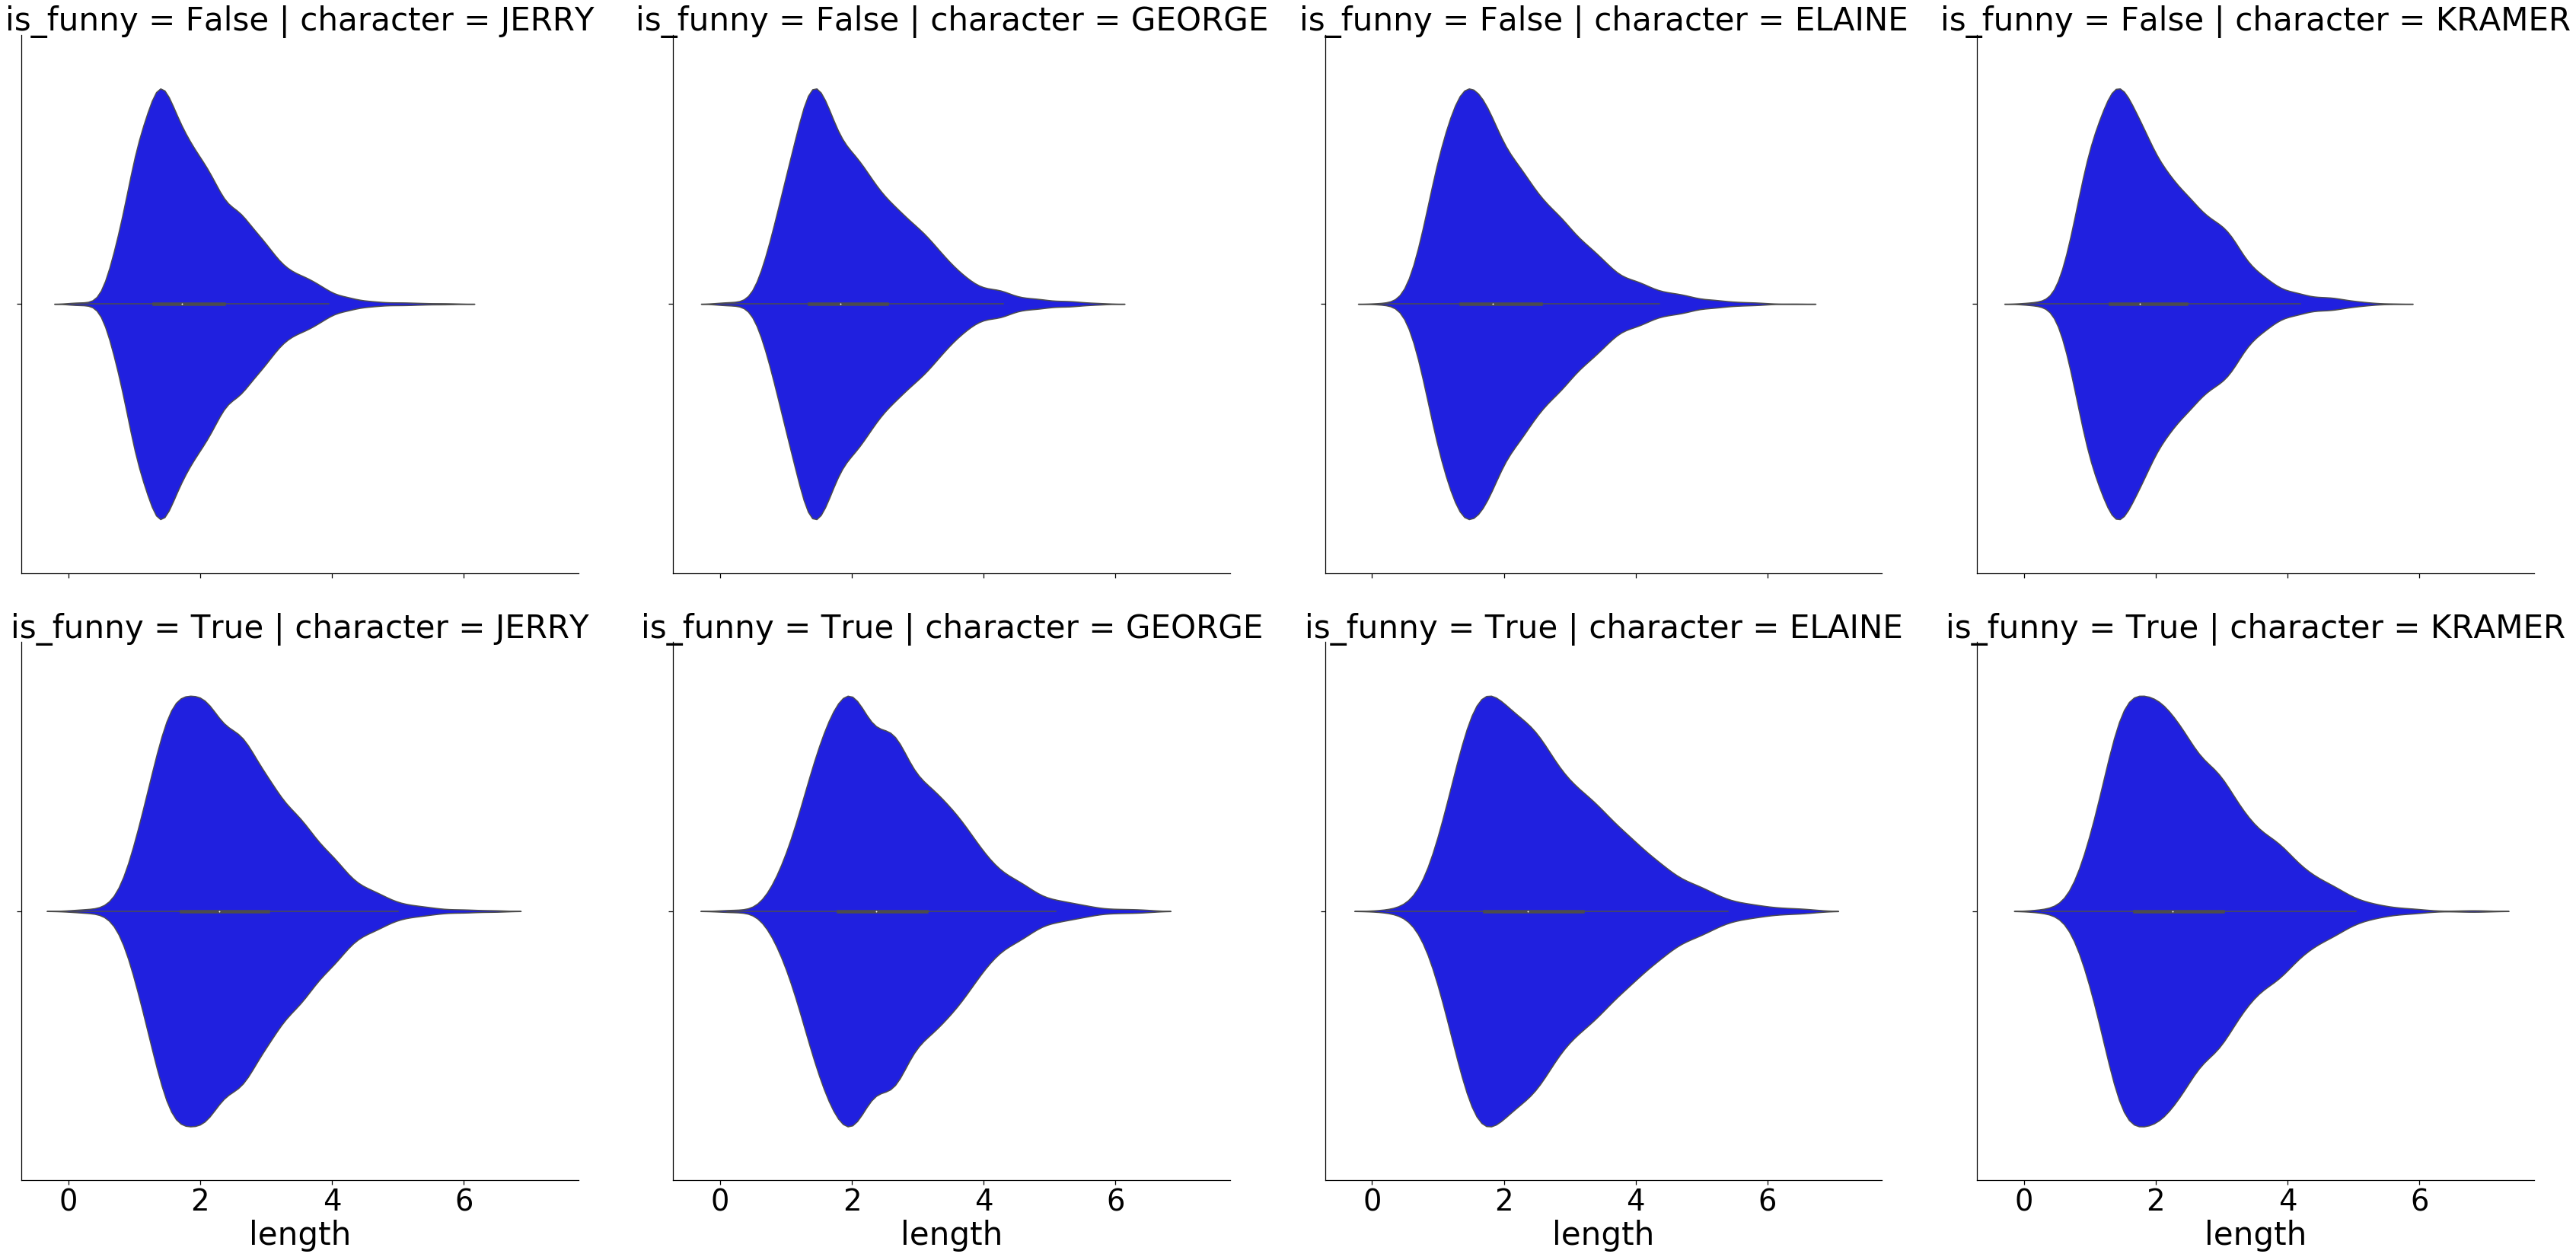

In [7]:
def plot_per_character_cross_is_funny(df, colname):
    with sns.plotting_context("notebook", font_scale=3.5):
        g = sns.FacetGrid(df, col='character', row='is_funny', height=12, sharex=True, sharey=True)
        g.map(sns.violinplot, colname, bins=50, color='b')
        plt.show()

plot_per_character_cross_is_funny(df_main_characters, "num_words")   # Sentence's length in #words
plot_per_character_cross_is_funny(df_main_characters, "length")      # Sentence's length in seconds

We can see that the distributions of the lengthes are slightly different between funny and not-funny sentences.  
It seems that funny sentences have "bigger tail".  
However, it's not obvious that this is significant.  
Let's try to see it numerically...

In [8]:
df_main_characters.groupby(["character", "is_funny"]).describe()['num_words']

count      mean       std  min  25%  50%  75%   max
character is_funny                                                      
ELAINE    False     5181.0  5.734221  3.374988  1.0  3.0  5.0  8.0  18.0
          True      1763.0  5.785593  3.632130  1.0  3.0  5.0  8.0  18.0
GEORGE    False     6093.0  5.913836  3.369355  1.0  3.0  6.0  8.0  18.0
          True      2703.0  6.295228  3.667046  1.0  3.0  6.0  9.0  19.0
JERRY     False     8357.0  5.802800  3.422097  1.0  3.0  5.0  8.0  19.0
          True      3659.0  6.411588  3.731420  1.0  3.0  6.0  9.0  19.0
KRAMER    False     4318.0  5.800602  3.355106  1.0  3.0  5.0  8.0  17.0
          True      2177.0  6.083142  3.576883  1.0  3.0  6.0  8.0  17.0

In [10]:
df_main_characters.groupby(["character", "is_funny"]).describe()['length']

count      mean       std    min    25%    50%    75%  \
character is_funny                                                           
ELAINE    False     5181.0  2.029553  0.908123  0.116  1.347  1.829  2.555   
          True      1763.0  2.541912  1.066384  0.210  1.708  2.364  3.194   
GEORGE    False     6093.0  2.006164  0.869716  0.014  1.348  1.829  2.534   
          True      2703.0  2.517910  0.968263  0.100  1.795  2.367  3.126   
JERRY     False     8357.0  1.890218  0.798056  0.049  1.300  1.727  2.364   
          True      3659.0  2.426743  0.932661  0.034  1.716  2.295  3.034   
KRAMER    False     4318.0  1.933257  0.840627  0.019  1.305  1.761  2.466   
          True      2177.0  2.437329  0.984176  0.274  1.676  2.261  3.023   

                      max  
character is_funny         
ELAINE    False     6.403  
          True      6.597  
GEORGE    False     5.834  
          True      6.437  
JERRY     False     5.902  
          True      6.505  
KRAMER    False     5.587  
          True      6.934

We can see that the numbers are indeed slightly lower for not-funny sentences.  
But the large standard deviation makes it not significant, so we can not really separate funniness by length (somewhat obvious).

## Word Clouds
First we split by character and see its word-cloud.  
We try to see the petterns of words chosen by each character.  
Are there words that characterize each one?

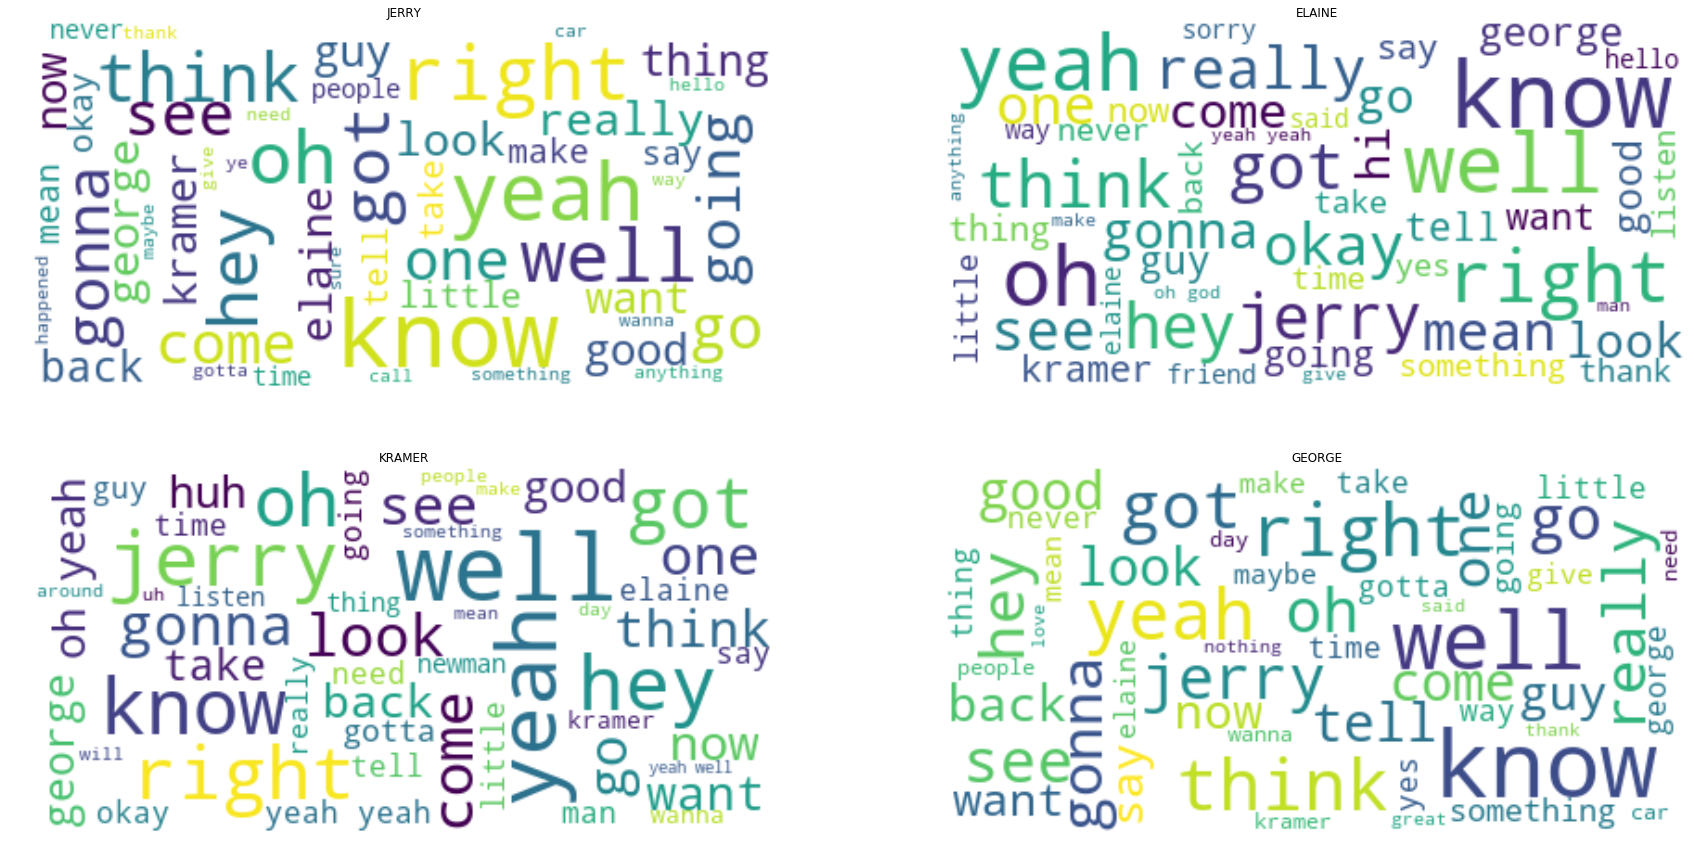

In [11]:
plt.figure(figsize=(30, 15))

for i, character in enumerate(["JERRY", "ELAINE", "KRAMER", "GEORGE"]):
    character_df = df[df['character'] == character]
    character_text = " ".join(character_df.txt).lower()
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(character_text)
    
    plt.subplot(2, 2, i+1)
    plt.title(character)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
              
plt.show()

We can see that the most common words (bigger words in the word-cloud) are common between the characters.  
Indeed, they are general words in english that everyone use, such as 'know', 'yeah', 'right', etc...  
  
Let's try to see if we can see different patterns in the word-clouds of funny/not-funny sentences.

Jerry's word-cloud:


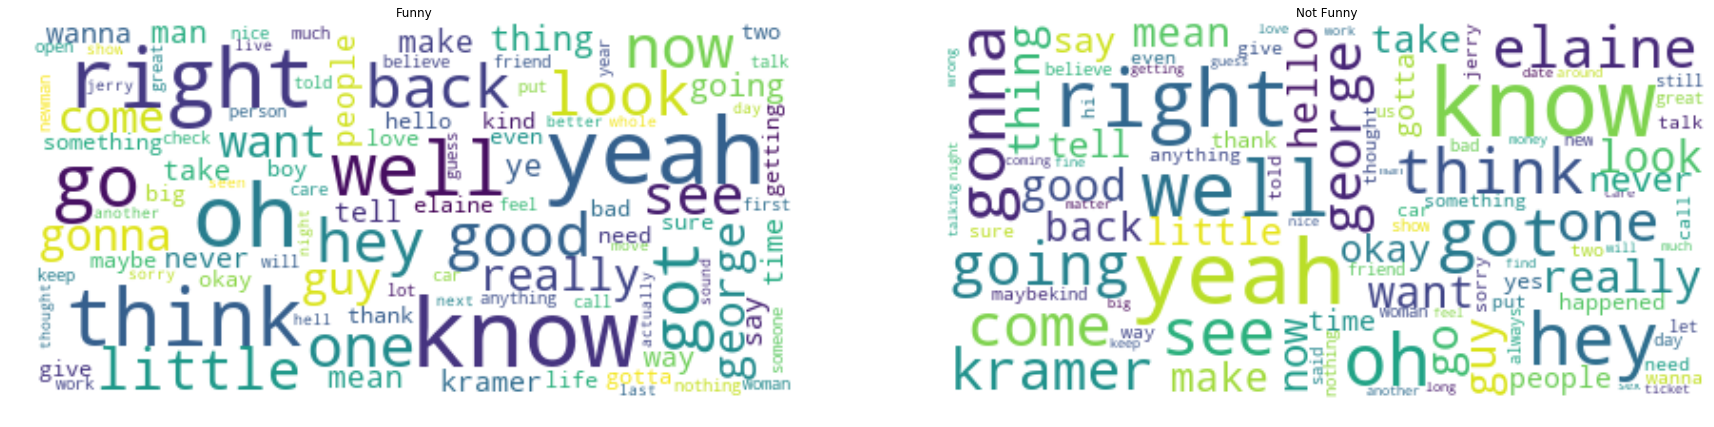

Elaine's word-cloud:


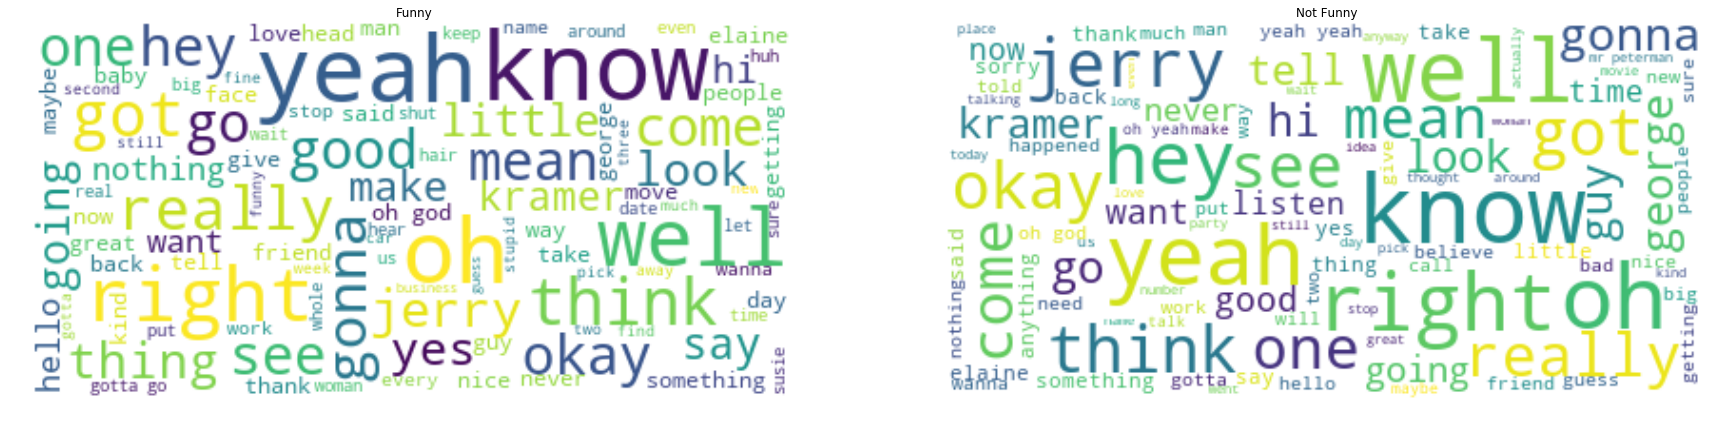

Kramer's word-cloud:


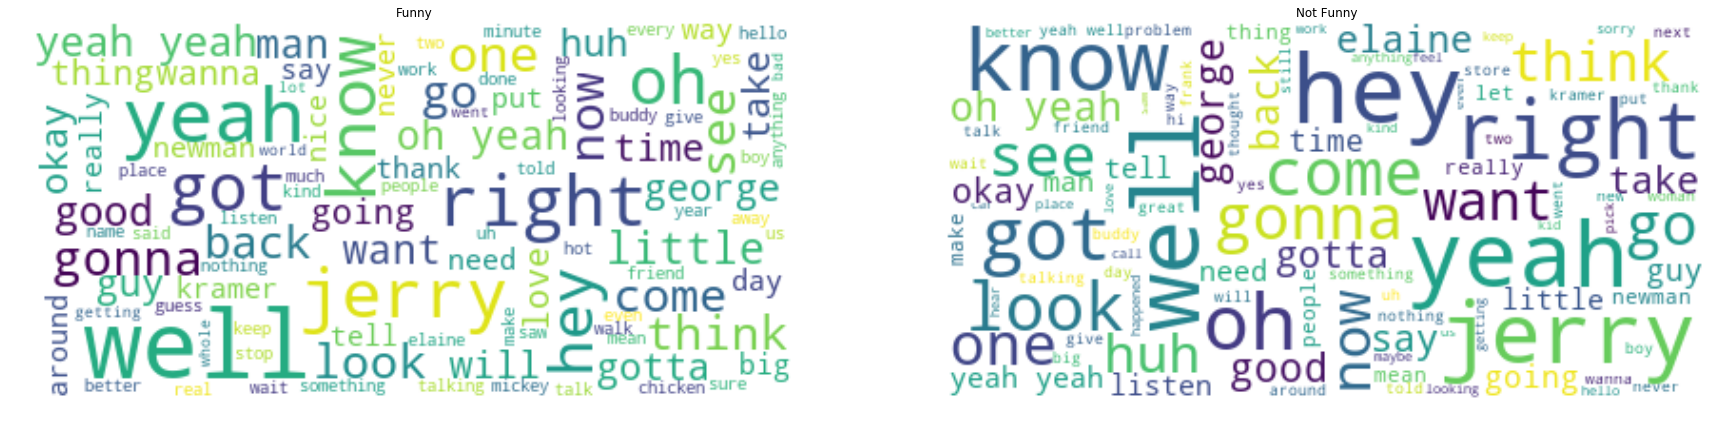

George's word-cloud:


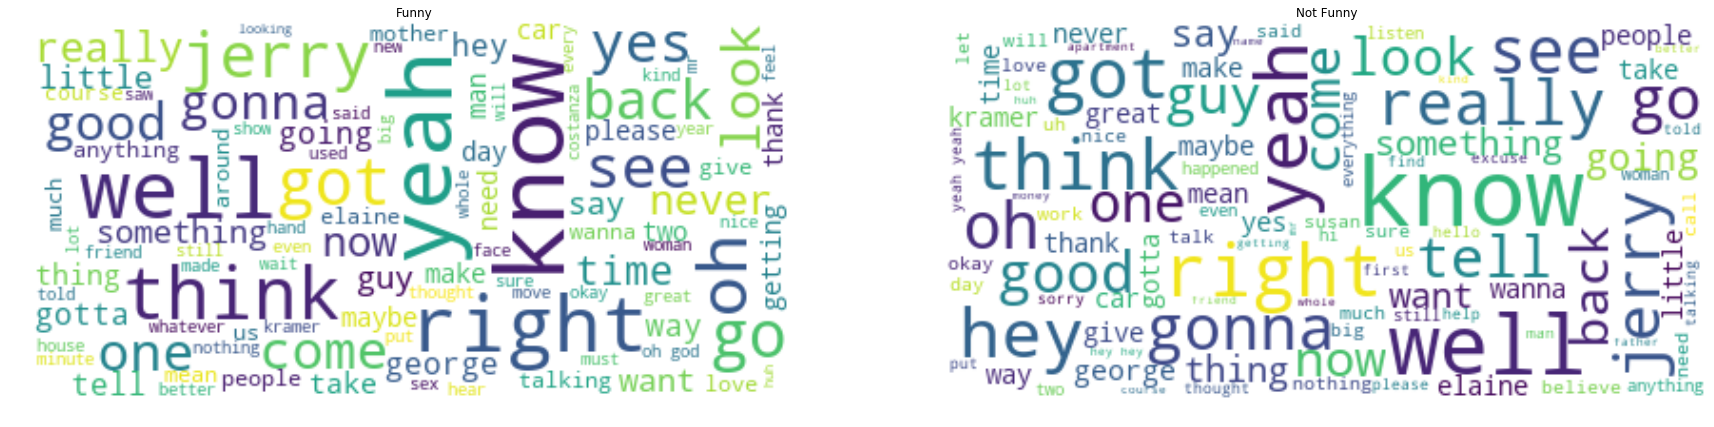

In [12]:
def plot_wordcloud(df, character):
    """
    Plot word-cloud for the given character
    """
    character_df = df[df['character'] == character]
    
    character_funny_text = " ".join(character_df[character_df['is_funny'] == True].txt).lower()
    character_not_funny_text = " ".join(character_df[character_df['is_funny'] == False].txt).lower()
    
    wordcloud_funny = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(character_funny_text)
    wordcloud_not_funny = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(character_not_funny_text)
    
    plt.figure(figsize=(30, 30))
    plt.subplot(121)
    plt.title("Funny")
    plt.axis("off")
    plt.imshow(wordcloud_funny, interpolation="bilinear")
    plt.subplot(122)
    plt.title("Not Funny")
    plt.axis("off")
    plt.imshow(wordcloud_not_funny, interpolation="bilinear")
    plt.show()

print("Jerry's word-cloud:")
plot_wordcloud(df, "JERRY")
print("Elaine's word-cloud:")
plot_wordcloud(df, "ELAINE")
print("Kramer's word-cloud:")
plot_wordcloud(df, "KRAMER")
print("George's word-cloud:")
plot_wordcloud(df, "GEORGE")

These word-clouds are just fun to look at...
We can see that there are many common frequent words between funny/not-funny sentences.  
However, we can see some interesting issues.  
For example, in Jerry's not-funny sentences the word 'Elaine' is more common. Can we learn that when Jerry says 'Elaine' in a sentence it is less likely to be funny?

# Network Graph
We want to understand the interaction between the different characters.  
Of course all of us saw Seinfeld, we want to see the connections!  
  
We will draw a network graph, which is based on the scenes.  
Each node is a character (from the nature of our data it's only characters the talked), where an edge between _s1_ and _s2_ means that _s1_ and _s2_ were together in the same scene.  (i.e. if _s1_, _s2_ and _s3_ were together in the scene we will have (3 choose 2) edges from this scene).  
We give weights to the edges according to the amount of times two characters  

In [4]:
import networkx as nx
import itertools
from bokeh.io import show, output_notebook, reset_output #output_file, 
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import HoverTool,BoxZoomTool, ResetTool, TapTool, Plot, Range1d, Circle, MultiLine
from bokeh.models.sources import ColumnDataSource
from bokeh.palettes import Spectral4

reset_output()
output_notebook()

Loading BokehJS ...

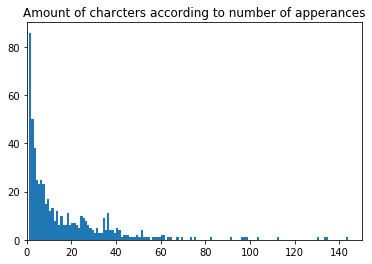

In [5]:
charcter_apperance = df.groupby(['character']).size()
plt.hist(charcter_apperance, bins=np.arange(0,150))
plt.xlim(0,150)
plt.title("Amount of charcters according to number of apperances")
plt.show()

As always, there is no clear cut, we can see that until ~40, there are a lot of charcthers that we didn't see much.  
After 40, the histogram is more smooth  
So we will make the cut at 40    

In [6]:
min_apperance = 40
freq_apperance = charcter_apperance[charcter_apperance > min_apperance]
print("we filter our {} charcters".format(len(charcter_apperance) - sum(charcter_apperance > min_apperance)))

we filter our 513 charcters


In [8]:
# Let's filter some charcters 
df_scene = getSceneData(df[df.character.isin(freq_apperance.index)].reset_index())
df_scene.head(1)

index character   end episode_name  episode_num  is_funny  laugh_time  \
0      0     JERRY  3.05    The Watch            6      True         3.6   

   length  line_num  num_words         ...           total_lines  \
0   1.944         0          9         ...                   486   

                                                 txt  global_episode_num  \
0  Here's what happened last  week, incase you mi...                   1   

  time_from_prev  new_scene  \
0            0.0       True   

                                          scene_text  scene_characters  \
0  Here's what happened last  week, incase you mi...    {MORTY, JERRY}   

  n_scene_characters scene_number_in_episode  global_scene_number  
0                  2                       1                    1  

[1 rows x 22 columns]

In [9]:
community_df = df_scene[df_scene['character'].isin(freq_apperance.index)]
community_df = df_scene[['scene_number_in_episode', 'global_scene_number', 'scene_characters', 'is_funny', 'season']]

In [13]:
# add for each scene if the scene funny
funny_scene_df = pd.DataFrame(community_df.groupby(by='global_scene_number')['is_funny'].sum() > 0)
def add_funny_scecne(x, df):
    return [x.is_funny] * sum(df.global_scene_number == x.name)
funny_scene_ls = funny_scene_df.apply(add_funny_scecne, args=(community_df,), axis=1)
funny_scene = [st for row in funny_scene_ls for st in row]
community_df.loc[:, ['is_scene_funny']] = funny_scene
community_df.head(1)

scene_number_in_episode  global_scene_number scene_characters  is_funny  \
0                        1                    1   {MORTY, JERRY}      True   

   season  is_scene_funny  
0       4            True

In [14]:
graph = []
for idx, row in community_df.iterrows():
#     print(row['scene_characters'])
    if len(row['scene_characters']) > 1:
        for comb in list(itertools.combinations(row['scene_characters'], 2)):
            # sort by abc so always same order
            char_1, char_2 = sorted(comb)
            graph.append({'char_1' : char_1, 'char_2' : char_2, **row.drop('scene_characters').to_dict()})
df_graph = pd.DataFrame(graph)
# df_graph.head(1)

weight_graph = df_graph[['char_1', 'char_2']].drop_duplicates()
weight_graph = weight_graph.set_index(['char_1', 'char_2'])
weight_graph['weight'] = df_graph.groupby(['char_1', 'char_2']).size()
weight_graph.reset_index(inplace=True)
weight_graph.head()

char_1 char_2  weight
0   JERRY  MORTY     826
1   HELEN  MORTY     780
2   HELEN  JERRY     879
3  GEORGE    LEO     205
4   JERRY    LEO     281

In [15]:
g = nx.from_pandas_edgelist(weight_graph, source='char_1', target='char_2', 
                            edge_attr=['char_1', 'char_2', 'weight'])
plot = figure(title="senfiled charcters scenes", x_range=(-2.1,2.1), 
              y_range=(-2.1,2.1), tools="pan")


pos = nx.spring_layout
graph = from_networkx(g, pos, scale=2, center=(0,0))

# Change node size porotional to degree
node_size = {k : np.log(v) ** 2 for k,v in g.degree()}
nx.set_node_attributes(g, node_size, 'node_size')
source=ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in g.nodes(data=True)},orient='index'))
graph.node_renderer.data_source = source

graph.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph.node_renderer.selection_glyph = Circle(size='node_size', fill_color=Spectral4[2])
graph.node_renderer.hover_glyph = Circle(size='node_size', fill_color=Spectral4[1])

graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

# set edge weight proprtional to the weight
edge_weight = np.array([g.get_edge_data(a,b)['weight'] for a, b in g.edges()])
edge_weight = np.log(edge_weight)
graph.edge_renderer.data_source.data["line_width"] = edge_weight
graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

# Add tooltip for edges with: both nodes & the weight 
graph.inspection_policy = EdgesAndLinkedNodes()
edge_hover_tool = HoverTool(tooltips=[("char_1", "@char_1"), ("char_2", "@char_2"),
                                      ("#scence", "@weight")])
plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool())

plot.renderers.append(graph)
show(plot)

ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='1031', ...)
